In [0]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
from IPython.display import Image
from IPython.core.display import Image, display
import numpy as np

batch_size = 100
 
dataset = datasets.MNIST(root='./mnist_data/',
                              train=True,
                              transform=transforms.ToTensor(),
                              download=True)

dataloader = torch.utils.data.DataLoader(dataset=dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

test_dataset = datasets.MNIST(root='./mnist_data/',
                              train=False,
                              transform=transforms.ToTensor(),
                              download=True)

test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [82]:
from google.colab import drive

drive.mount('/gdrive')
gdrive_root = '/gdrive/My Drive/results/'

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [7]:
len(dataset), len(dataloader)

(60000, 600)

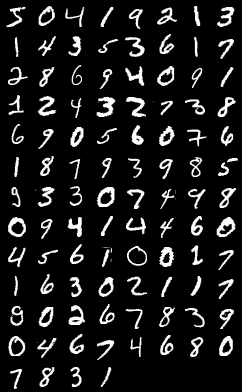

In [10]:
fixed_x, _ = next(iter(dataloader))
save_image(fixed_x, 'real_image.png')

Image('real_image.png')

In [0]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [0]:
class UnFlatten(nn.Module):
    def forward(self, input, size=28*28):
        return input.view(input.size(0), 40, 5, 5)

In [0]:
class VAE(nn.Module):
    def __init__(self, image_channels, h_dim=25*40, z_dim=32):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 10, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Conv2d(10, 20, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv2d(20, 30, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Conv2d(30, 40, kernel_size=2, stride=1),
            nn.ReLU(),
            Flatten()
        )
        
        self.fc1 = nn.Linear(h_dim, z_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, h_dim)
        
        self.decoder = nn.Sequential(
             UnFlatten(),
            # nn.ConvTranspose2d(h_dim, 128, kernel_size=14, stride=1),
             nn.ConvTranspose2d(40, 30, kernel_size=4, stride=1),
             nn.ReLU(),
             nn.ConvTranspose2d(30, 30, kernel_size=4, stride=1),
             nn.ReLU(), 
             nn.ConvTranspose2d(30, 30, kernel_size=5, stride=1),    
             nn.ReLU(), 
             nn.ConvTranspose2d(30, 20, kernel_size=6, stride=1),  
             nn.ReLU(), 
             nn.ConvTranspose2d(20, 10, kernel_size=5, stride=1),  
             nn.ReLU(), 
             nn.ConvTranspose2d(10, 1, kernel_size=5, stride=1),   
            # #nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2),
            #nn.ReLU(),
            # nn.ConvTranspose2d(64, 32, kernel_size=6, stride=2),
            # nn.ReLU(),
            # nn.ConvTranspose2d(32, image_channels, kernel_size=6, stride=2),
             nn.Sigmoid(),
        )
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size())
        z = mu + std * esp
        return z
    
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    def decode(self, z):
        z = self.fc3(z)
        z = self.decoder(z)
        return z

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        z = self.decode(z)
        return z, mu, logvar

In [154]:
image_channels = fixed_x.size(1)
print(len(fixed_x))
model = VAE(image_channels=image_channels).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

100


In [155]:
ckpt_dir = os.path.join(gdrive_root, 'checkpoints')
if not os.path.exists(ckpt_dir):
  os.makedirs(ckpt_dir)
  
best_loss = 99999
ckpt_path = os.path.join(ckpt_dir, 'lastest.pt')
if os.path.exists(ckpt_path):
  ckpt = torch.load(ckpt_path)
  try:
    model.load_state_dict(ckpt['VAE_model'])
    optimizer.load_state_dict(ckpt['optimizer'])
    best_loss = ckpt['best_loss']
  except RuntimeError as e:
      print('wrong checkpoint')
  else:    
    print('checkpoint is loaded !')
    print('current best loss : %.2f' % best_loss)

checkpoint is loaded !
current best loss : 19086.84


In [0]:
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

In [0]:
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(dataloader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(dataloader.dataset),
                100. * batch_idx / len(dataloader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(dataloader.dataset)))
    return train_loss

In [0]:
def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_dataloader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(batch_size, 1, 28, 28)[:n]])
                save_image(comparison.cpu(),
                         gdrive_root + 'reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_dataloader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))
    return test_loss

    

In [164]:
for epoch in range(1, 100):
    train(epoch)
    test_loss = test(epoch)
    print(test_loss, best_loss)
    # save checkpoint whenever there is improvement in performance
    if test_loss < best_loss:
      best_loss = test_loss
      # Note: optimizer also has states ! don't forget to save them as well.
      ckpt = {'VAE_model':model.state_dict(),
              'optimizer':optimizer.state_dict(),
              'best_loss':best_loss}
      torch.save(ckpt, ckpt_path)
      print('checkpoint is saved !')

    with torch.no_grad():
        sample = torch.randn(64, 32).to(device)
        sample = model.decode(sample).cpu()
        print("saving image..")
        save_image(sample.view(64, 1, 28, 28),
                    gdrive_root + 'sample_' + str(epoch) + '.png')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Using a target size (torch.Size([100, 784])) that is different to the input size (torch.Size([100, 1, 28, 28])) is deprecated. Please ensure they have the same size.
  


====> Test set loss: 122.7550
122.7550111328125 19086.841796875
checkpoint is saved !
saving image..
====> Test set loss: 122.6380
122.63804287109375 122.7550111328125
checkpoint is saved !
saving image..


KeyboardInterrupt: ignored

In [209]:
#print(dataset[0])
import pandas as pd

print(len(dataset))
print(len(dataset[0][0][0]))
#print(dataset[0][0][0].tolist())

latent_vector = []

for i, (data, _) in enumerate(test_dataloader):
  data = data.to(device)
  z, _, _ = model.encode(data)
  latent_vector += z.tolist()
  if (i+1) % 5 == 0 :
    break

dataframe = pd.DataFrame(latent_vector)
dataframe.to_csv(gdrive_root + '/data.csv', header = False, index = False)
print(latent_vector)
print(len(latent_vector))
print(len(latent_vector[0]))
# index, channel, 가로, 세로

60000
28
[[-0.6776438355445862, -1.4910038709640503, 1.4321435689926147, -0.032541424036026, -0.0786697268486023, -0.4103541374206543, 1.4381954669952393, 1.0299875736236572, 0.5027146339416504, -0.17260369658470154, 0.4945169687271118, 1.0925023555755615, -1.3773808479309082, -0.9155339002609253, -0.3310840129852295, -1.2842390537261963, 1.2276637554168701, -0.6099668145179749, -0.03383254259824753, 0.4315881133079529, 1.3790194988250732, -2.4334793090820312, -0.2659320831298828, -0.10644086450338364, 0.636273205280304, 1.2360533475875854, -0.7177265882492065, 0.014708634465932846, 1.191893458366394, -0.5254833698272705, 0.704012393951416, 1.2977941036224365], [1.8860323429107666, 0.29788869619369507, -1.2997524738311768, -0.2699050307273865, -0.5058856010437012, 0.15985703468322754, -0.09576699137687683, 3.2988643646240234, 0.9227094650268555, -2.4298715591430664, -0.024888023734092712, 0.3442121148109436, 0.15839314460754395, 0.183889240026474, 0.9703726172447205, 1.7252931594848633